# Libraries 

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings

# hides error messages 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



# Loading in Data 

In [3]:
ng_df = pd.read_csv('Nat Gas.csv', parse_dates=['Dates'], index_col=['Dates'])
ng_df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


# Visualising Data

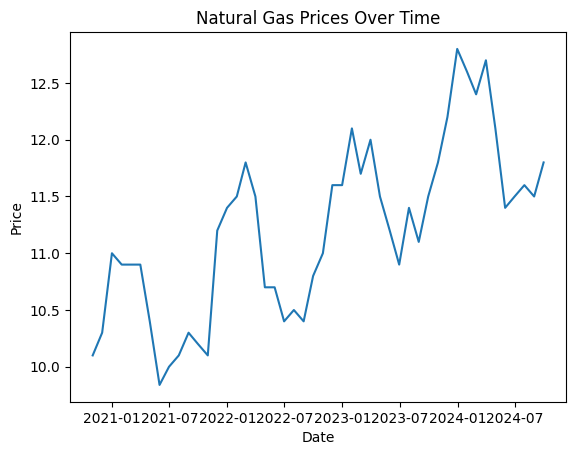

In [7]:
plt.plot(ng_df)
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

we can see the data is cyclical

# Checking for Stationarity 

In [8]:
print(f"p-value: {adfuller(ng_df['Prices'])[1]}")

p-value: 0.9732574388448689


since the p value is so large (nearly 1) we know the data is non-stationary

## d, p and q

In [9]:

ng_df['price_diff'] = ng_df['Prices'].diff().dropna()
print(f"p-value: {adfuller(ng_df['price_diff'].dropna())[1]}")


p-value: 1.754169685294014e-09


Takes one differencing to get a suitable p value, hence use d=1

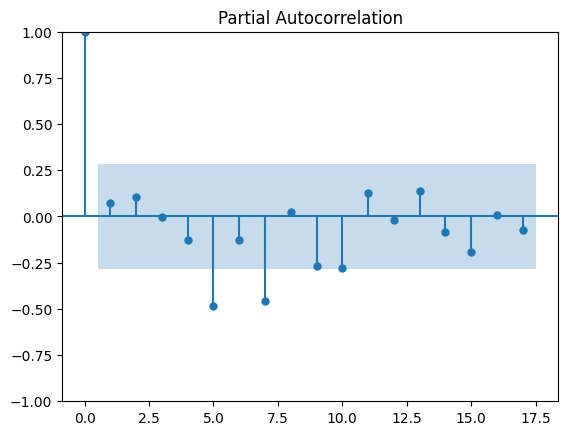

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ng_df['Prices'].diff().dropna());

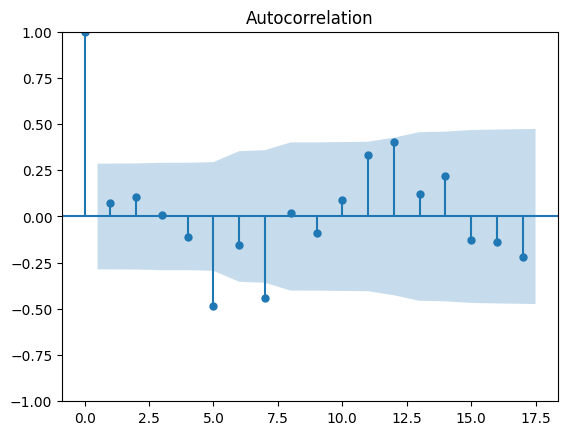

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ng_df['Prices'].diff().dropna());

# Fitting and Forecasting

In [12]:
# using d=1, p=1, q=1 as found above and m=12 as one period is 12 months in this data set
model = SARIMAX(ng_df['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# forecasting the next 12 months and getting the CI
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# creating an index and a series to store the forecasted data in - makes later processes easier 
forecast_index = pd.date_range(start=ng_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54046D-01    |proj g|=  3.48180D-01


 This problem is unconstrained.



At iterate    5    f=  2.66288D-02    |proj g|=  7.25256D-02

At iterate   10    f=  1.45537D-02    |proj g|=  2.89977D-02

At iterate   15    f=  1.35116D-02    |proj g|=  1.62256D-02

At iterate   20    f=  1.33605D-02    |proj g|=  7.54182D-03

At iterate   25    f=  1.33495D-02    |proj g|=  7.37204D-04

At iterate   30    f=  1.33455D-02    |proj g|=  6.52872D-04

At iterate   35    f=  1.33452D-02    |proj g|=  1.39811D-03

At iterate   40    f=  1.33450D-02    |proj g|=  1.30865D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     62      1     0     0   5.344D-04   1.335D-02
  F =   1.33450374371

# Past Date Estimate Function

In [13]:
def estimate_price(date):

    # changes any date passed in to datetime format 
    date = pd.to_datetime(date)

    # coppies the original df and sets new one to daily freq to interpolate 
    ng_daily = ng_df.copy()
    ng_daily = ng_daily.asfreq('D')
    ng_daily['price_interpolated'] = ng_daily['Prices'].interpolate(method='linear')

    # created a reversed daily df - used to make backcasting more accurate 
    ng_daily_reversed = ng_daily[::-1]

    # creates a daily forecast df using the forecast series for interpolation 
    forecast_daily = forecast_series.asfreq('D').interpolate(method='linear')


    # if date in the historic data send back price 
    if date in ng_daily.index:
        return ng_daily.loc[date, 'price_interpolated']
    
    # if date not in historic data 
    else:

        # backcasting
        if date < ng_daily.index[0]: 

            # reverse model for backcasting 
            model_backcast = SARIMAX(ng_daily_reversed['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            backcast_results = model_backcast.fit(disp=False)
            
    
            backcasting_days = (ng_daily.index[0] - date).days
            backcast = backcast_results.get_forecast(steps=backcasting_days)
            backcast_index = pd.date_range(end=ng_daily.index[0] - pd.Timedelta(days=1),periods=backcasting_days, freq='D')
            
            # reverses backcast prediction to match original order
            backcast_series = pd.Series(backcast.predicted_mean.values, index=backcast_index[::-1])

            return backcast_series.loc[date]


        # forecasting using one year forecast
        elif date > ng_daily.index[-1]:  
            if date in forecast_daily.index:
                return forecast_daily.loc[date]
            else:
                print(f"Date {date} is outside the forecasted range.")
                return None

# Visualising Forecast 

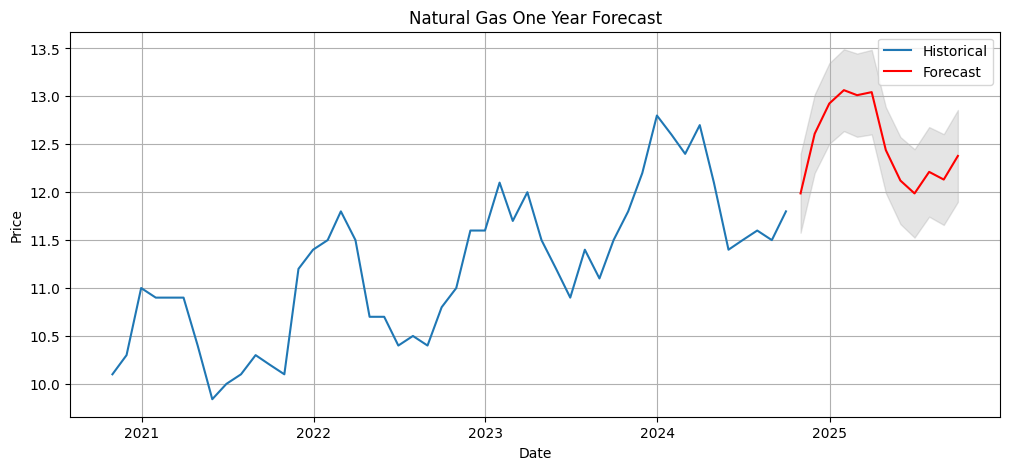

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(ng_df['Prices'], label='Historical')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='grey', alpha=0.2)
plt.title('Natural Gas One Year Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

# Past Date Estimate Parameters

In [16]:
dates = ['2020-08-15', '2025-08-01']

for date in dates:
    estimated_price = estimate_price(date)
    if estimated_price is not None:
        print(f"Estimated price for {date}: {estimated_price:.2f}")
    else:
        print(f"Could not estimate price for {date}.")


Estimated price for 2020-08-15: 10.12
Estimated price for 2025-08-01: 12.21
